In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define evaluation functions

def MAPE(v, v_, axis=None):
    mask = v != 0  # Ignore samples where true value is 0
    if np.any(mask):
        mape = (np.abs(v_[mask] - v[mask]) / np.abs(v[mask])).astype(np.float64)
        mape = np.where(mape > 5, 5, mape)
        return np.mean(mape, axis)
    else:
        return np.nan  # Or some default if all are zero

def RMSE(v, v_, axis=None):
    return np.sqrt(np.mean((v_ - v) ** 2, axis)).astype(np.float64)

def MAE(v, v_, axis=None):
    return np.mean(np.abs(v_ - v), axis).astype(np.float64)

In [21]:
# Evaluate all methods
methods = ['stemgnn', 'mtgnn', 'baseline']


for method in methods:
    try:
        if method == 'stemgnn':
            target_train = np.loadtxt('../../baselines_imputation/StemGNN/output/confirmed_state/train/target.csv', delimiter=',')[:-10]
            target_test = np.loadtxt('../../baselines_imputation/StemGNN/output/confirmed_state/test/target.csv', delimiter=',')[:-10]
            predict_train = np.loadtxt('../../baselines_imputation/StemGNN/output/confirmed_state/train/predict.csv', delimiter=',')[:-10]
            predict_test = np.loadtxt('../../baselines_imputation/StemGNN/output/confirmed_state/test/predict.csv', delimiter=',')[:-10]
        elif method == 'mtgnn':
            # Load predictions and targets
            target_train = np.loadtxt('../../baselines_imputation/MTGNN/predictions/val_ground_truth.csv', delimiter=',')
            target_test = np.loadtxt('../../baselines_imputation/MTGNN/predictions/test_ground_truth.csv', delimiter=',')
            predict_train = np.loadtxt('../../baselines_imputation/MTGNN/predictions/val_first_step_predictions.csv', delimiter=',')
            predict_test = np.loadtxt('../../baselines_imputation/MTGNN/predictions/test_first_step_predictions.csv', delimiter=',')
        elif method == 'baseline':
            # Naive baseline: use previous day's value to predict next day
            target_train = np.loadtxt('../../baselines_imputation/MTGNN/predictions/val_ground_truth.csv', delimiter=',')
            target_test = np.loadtxt('../../baselines_imputation/MTGNN/predictions/test_ground_truth.csv', delimiter=',')
            # For baseline, prediction is just the previous time step
            predict_train = target_train[:-1]  # Use t to predict t+1, so remove last element
            predict_test = target_test[:-1]    # Use t to predict t+1, so remove last element
            target_train = target_train[1:]    # Remove first element to align
            target_test = target_test[1:]      # Remove first element to align

        # Adjust dimensions if needed (e.g., for lin_reg)
        # if method != 'stemgnn':
        #     predict_train = predict_train[13:-1]
        #     predict_test = predict_test[13:-1]

        # Compute metrics on all samples
        mape_train = MAPE(target_train, predict_train)
        rmse_train = RMSE(target_train, predict_train)
        mae_train = MAE(target_train, predict_train)

        mape_test = MAPE(target_test, predict_test)
        rmse_test = RMSE(target_test, predict_test)
        mae_test = MAE(target_test, predict_test)

        print(f"\n{method.upper()} Evaluation:")
        print(f"Train - MAPE: {mape_train:.4f}, RMSE: {rmse_train:.4f}, MAE: {mae_train:.4f}")
        print(f"Test - MAPE: {mape_test:.4f}, RMSE: {rmse_test:.4f}, MAE: {mae_test:.4f}")

    except Exception as e:
        
        print(f"Error evaluating {method}: {e}. Skipping.")


STEMGNN Evaluation:
Train - MAPE: 1.2244, RMSE: 2175.7234, MAE: 1343.0010
Test - MAPE: 2.5969, RMSE: 3339.3437, MAE: 2172.1569

MTGNN Evaluation:
Train - MAPE: 0.1023, RMSE: 348.7297, MAE: 116.9195
Test - MAPE: 0.1460, RMSE: 322.1289, MAE: 90.8607

BASELINE Evaluation:
Train - MAPE: 0.0606, RMSE: 355.2746, MAE: 97.6610
Test - MAPE: 0.0588, RMSE: 317.0158, MAE: 64.3002


Train - Predict shape: (132, 49), Target shape: (132, 49)
Test - Predict shape: (60, 49), Target shape: (60, 49)


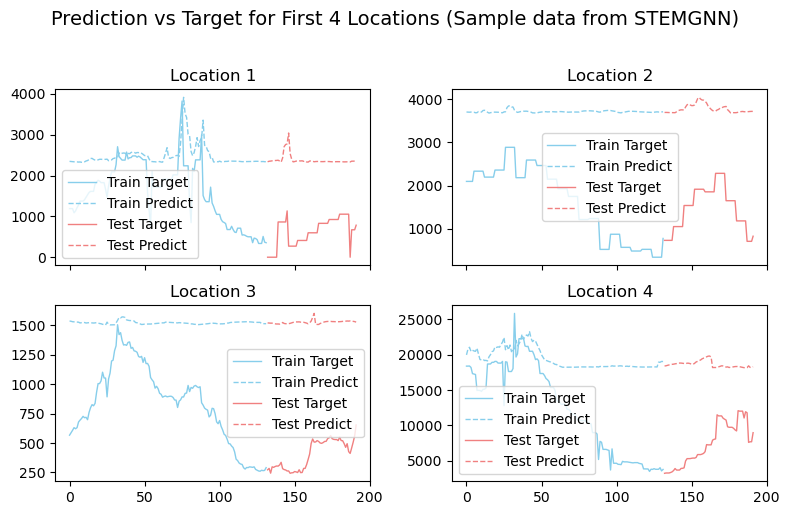

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load train data
predict_train = np.loadtxt('../../baselines_imputation/StemGNN/output/confirmed_state/train/predict.csv', delimiter=',')
target_train = np.loadtxt('../../baselines_imputation/StemGNN/output/confirmed_state/train/target.csv', delimiter=',')

# Load test data
predict_test = np.loadtxt('../../baselines_imputation/StemGNN/output/confirmed_state/test/predict.csv', delimiter=',')
target_test = np.loadtxt('../../baselines_imputation/StemGNN/output/confirmed_state/test/target.csv', delimiter=',')

print(f"Train - Predict shape: {predict_train.shape}, Target shape: {target_train.shape}")
print(f"Test - Predict shape: {predict_test.shape}, Target shape: {target_test.shape}")

# Plot for first 8 locations, train followed by test with different colors
n_loc = min(4, predict_train.shape[1])
cols = 2
rows = int(np.ceil(n_loc / cols))

fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 2.5*rows), sharex=True)
axes = axes.ravel()

for i in range(n_loc):
    ax = axes[i]
    # Plot train data with softer blue
    ax.plot(range(len(target_train)), target_train[:, i], label='Train Target', linewidth=1, color='skyblue')
    ax.plot(range(len(predict_train)), predict_train[:, i], label='Train Predict', linewidth=1, linestyle='--', color='skyblue')
    # Plot test data with softer red
    start_test = len(target_train)
    ax.plot(range(start_test, start_test + len(target_test)), target_test[:, i], label='Test Target', linewidth=1, color='lightcoral')
    ax.plot(range(start_test, start_test + len(predict_test)), predict_test[:, i], label='Test Predict', linewidth=1, linestyle='--', color='lightcoral')
    ax.set_title(f'Location {i+1}')
    ax.legend()

# Hide extra subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

fig.suptitle('Prediction vs Target for First 4 Locations (Sample data from STEMGNN)', y=1.02, fontsize=14)
plt.tight_layout()
plt.show()

Train - Predict shape: (122, 49), Target shape: (122, 49)
Test - Predict shape: (50, 49), Target shape: (50, 49)


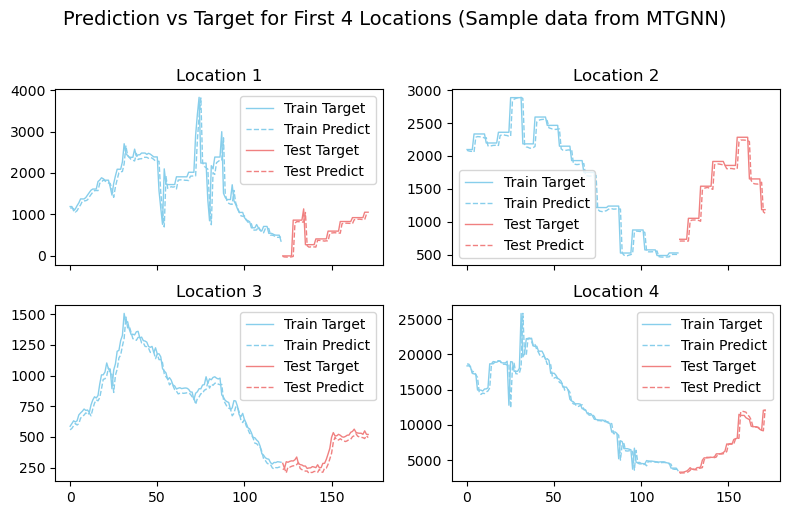

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load train data
predict_train = np.loadtxt('../../baselines_imputation/MTGNN//predictions/val_first_step_predictions.csv', delimiter=',')
target_train = np.loadtxt('../../baselines_imputation/MTGNN//predictions/val_ground_truth.csv', delimiter=',')

# Load test data
predict_test = np.loadtxt('../../baselines_imputation/MTGNN//predictions/test_first_step_predictions.csv', delimiter=',')
target_test = np.loadtxt('../../baselines_imputation/MTGNN//predictions/test_ground_truth.csv', delimiter=',')

print(f"Train - Predict shape: {predict_train.shape}, Target shape: {target_train.shape}")
print(f"Test - Predict shape: {predict_test.shape}, Target shape: {target_test.shape}")

# Plot for first 8 locations, train followed by test with different colors
n_loc = min(4, predict_train.shape[1])
cols = 2
rows = int(np.ceil(n_loc / cols))

fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 2.5*rows), sharex=True)
axes = axes.ravel()

for i in range(n_loc):
    ax = axes[i]
    # Plot train data with softer blue
    ax.plot(range(len(target_train)), target_train[:, i], label='Train Target', linewidth=1, color='skyblue')
    ax.plot(range(len(predict_train)), predict_train[:, i], label='Train Predict', linewidth=1, linestyle='--', color='skyblue')
    # Plot test data with softer red
    start_test = len(target_train)
    ax.plot(range(start_test, start_test + len(target_test)), target_test[:, i], label='Test Target', linewidth=1, color='lightcoral')
    ax.plot(range(start_test, start_test + len(predict_test)), predict_test[:, i], label='Test Predict', linewidth=1, linestyle='--', color='lightcoral')
    ax.set_title(f'Location {i+1}')
    ax.legend()

# Hide extra subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

fig.suptitle('Prediction vs Target for First 4 Locations (Sample data from MTGNN)', y=1.02, fontsize=14)
plt.tight_layout()
plt.show()